<a href="https://colab.research.google.com/github/zahraziran/Smart-Home/blob/main/Energy_consumption_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')

In [ ]:


import lightgbm as lgb

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import time
import datetime as datetime
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import plotly
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import cufflinks as cf
cf.set_config_file(offline=True)

In [ ]:
path_file = r'/kaggle/input/create-pickle-for-dataset/'

In [ ]:
df_data = pd.read_pickle(os.path.join(path_file, 'df_merged.pickle.gz'))
df_data

Floor1_z1_Light(kW)  Floor1_z1_Plug(kW)  \
Date                                                           
2018-07-01 00:00:00                12.94               18.56   
2018-07-01 00:01:00                12.97               18.55   
2018-07-01 00:02:00                12.97               18.55   
2018-07-01 00:03:00                12.98               18.58   
2018-07-01 00:04:00                13.01               18.60   
...                                  ...                 ...   
2019-12-31 23:55:00                 0.02                0.01   
2019-12-31 23:56:00                 0.02                0.02   
2019-12-31 23:57:00                 0.01                0.01   
2019-12-31 23:58:00                 0.01                0.01   
2019-12-31 23:59:00                 0.01                0.00   

                     Floor1_z2_AC1(kW)  Floor1_z2_AC2(kW)  Floor1_z2_AC3(kW)  \
Date                                                                           
2018-07-01 00:00:00              45.24               0.01               0.01   
2018-07-01 00:01:00              45.28               0.02               0.01   
2018-07-01 00:02:00              45.24               0.01               0.01   
2018-07-01 00:03:00              45.26               0.02               0.01   
2018-07-01 00:04:00              45.22               0.02               0.01   
...                                ...                ...                ...   
2019-12-31 23:55:00               2.22               0.03               0.00   
2019-12-31 23:56:00              13.14               0.02               0.01   
2019-12-31 23:57:00              51.20               0.03               0.01   
2019-12-31 23:58:00              40.38               0.03               0.00   
2019-12-31 23:59:00               2.23               0.03               0.01   

                     Floor1_z2_AC4(kW)  Floor1_z2_Light(kW)  \
Date                                                          
2018-07-01 00:00:00               0.00                13.76   
2018-07-01 00:01:00               0.01                13.76   
2018-07-01 00:02:00               0.01                13.79   
2018-07-01 00:03:00               0.00                13.81   
2018-07-01 00:04:00               0.01                13.83   
...                                ...                  ...   
2019-12-31 23:55:00               0.01                 8.85   
2019-12-31 23:56:00               0.00                 8.86   
2019-12-31 23:57:00               0.01                 8.90   
2019-12-31 23:58:00               0.00                 8.87   
2019-12-31 23:59:00               0.00                 8.88   

                     Floor1_z2_Plug(kW)  Floor1_z3_Light(kW)  \
Date                                                           
2018-07-01 00:00:00               17.64                10.92   
2018-07-01 00:01:00               17.21                10.95   
2018-07-01 00:02:00               17.18                10.94   
2018-07-01 00:03:00               16.64                10.94   
2018-07-01 00:04:00               15.69                10.97   
...                                 ...                  ...   
2019-12-31 23:55:00               27.00                10.98   
2019-12-31 23:56:00               27.15                10.98   
2019-12-31 23:57:00               20.62                11.03   
2019-12-31 23:58:00               17.81                11.03   
2019-12-31 23:59:00               17.44                11.00   

                     Floor1_z3_Plug(kW)  ...  Floor7_z4_Plug(kW)  \
Date                                     ...                       
2018-07-01 00:00:00                0.89  ...                0.00   
2018-07-01 00:01:00                0.87  ...                0.00   
2018-07-01 00:02:00                0.86  ...                0.00   
2018-07-01 00:03:00                0.85  ...                0.00   
2018-07-01 00:04:00                0.85  ...                0.00   
...               

In [ ]:
df_weather = pd.read_pickle(os.path.join(path_file, 'df_weather.pickle.gz'))
df_weather

Avg Temp  Min Temp  Max Temp  Precip
2018-01-01     26.72     23.00     31.22     0.0
2018-01-02     27.44     23.22     31.78     0.0
2018-01-03     27.83     24.78     31.50     0.0
2018-01-04     28.83     24.72     33.78     0.0
2018-01-05     29.61     25.50     34.00     0.0
...              ...       ...       ...     ...
2019-12-27     29.39     25.78     35.11     0.0
2019-12-28     27.78     24.50     31.50     0.0
2019-12-29     28.67     24.00     33.28     0.0
2019-12-30     28.00     23.39     32.72     0.0
2019-12-31     28.22     23.22     34.78     0.0

[730 rows x 4 columns]

In [ ]:
df_holiday_encode = pd.read_pickle(os.path.join(path_file, 'df_holiday_encode.pickle.gz'))
df_holiday_encode

Avg Temp  Min Temp  Max Temp  Precip
2018-01-01     26.72     23.00     31.22     0.0
2018-01-02     27.44     23.22     31.78     0.0
2018-01-03     27.83     24.78     31.50     0.0
2018-01-04     28.83     24.72     33.78     0.0
2018-01-05     29.61     25.50     34.00     0.0
...              ...       ...       ...     ...
2019-12-27     29.39     25.78     35.11     0.0
2019-12-28     27.78     24.50     31.50     0.0
2019-12-29     28.67     24.00     33.28     0.0
2019-12-30     28.00     23.39     32.72     0.0
2019-12-31     28.22     23.22     34.78     0.0

[730 rows x 4 columns]

In [ ]:
# Leave columns with keyword of 'kW'
df_powerMeter = df_data.loc[:, df_data.columns.str.contains('kW')].copy()
df_powerMeter = df_powerMeter.sum(axis=1).rename('total_demand')
df_powerMeter = df_powerMeter.resample('H').mean()
df_powerMeter

Date
2018-07-01 00:00:00    176.261667
2018-07-01 01:00:00    177.300000
2018-07-01 02:00:00    177.048833
2018-07-01 03:00:00    175.129167
2018-07-01 04:00:00    183.175000
                          ...    
2019-12-31 19:00:00    120.144500
2019-12-31 20:00:00    124.547667
2019-12-31 21:00:00    104.895333
2019-12-31 22:00:00     95.204167
2019-12-31 23:00:00     91.057667
Freq: H, Name: total_demand, Length: 13176, dtype: float64

In [ ]:
df_powerMeter.iplot()

# Regression & visualizations

In [ ]:
# Prepare data for modeling
df_temp = df_powerMeter.reset_index().copy()
df_temp = df_temp.dropna()

# Add timestamp features
df_temp['weekday'] = df_temp['Date'].dt.weekday
df_temp['hour'] = df_temp['Date'].dt.hour
df_temp['date'] =pd.to_datetime(df_temp['Date'].dt.date)

df_temp = df_temp.set_index('Date').drop(['date'],axis=1)

df_temp = df_temp.rename(columns={'total_demand':'total_demand_meas'})

df_temp

total_demand_meas  weekday  hour
Date                                                 
2018-07-01 00:00:00         176.261667        6     0
2018-07-01 01:00:00         177.300000        6     1
2018-07-01 02:00:00         177.048833        6     2
2018-07-01 03:00:00         175.129167        6     3
2018-07-01 04:00:00         183.175000        6     4
...                                ...      ...   ...
2019-12-31 19:00:00         120.144500        1    19
2019-12-31 20:00:00         124.547667        1    20
2019-12-31 21:00:00         104.895333        1    21
2019-12-31 22:00:00          95.204167        1    22
2019-12-31 23:00:00          91.057667        1    23

[13176 rows x 3 columns]

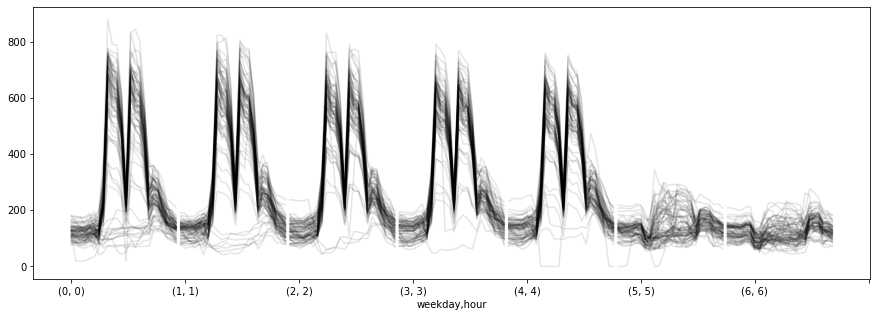

In [ ]:
# Weekly profiles of building energy
df_plot = df_temp.copy()
df_plot['date'] = pd.to_datetime(df_plot.index.date)
df_plot.pivot_table(columns=['weekday','hour'], index='date', values='total_demand_meas').T.plot(figsize=(15,5),color='black',alpha=0.1,legend=False)

In [ ]:
traindata = df_temp.loc['2018-7':'2019-6'].copy()
testdata = df_temp.loc['2019-7':].copy()

train_labels = traindata['total_demand_meas']
test_labels = testdata['total_demand_meas']

train_features = traindata.drop('total_demand_meas', axis=1)
test_features = testdata.drop('total_demand_meas', axis=1)

LGB_model = lgb.LGBMRegressor()
LGB_model.fit(train_features, train_labels)

testdata['total_demand_pred'] = LGB_model.predict(test_features)

df_temp.loc[testdata.index, 'total_demand_pred'] = testdata['total_demand_pred']

# Calculate the absolute errors
errors = abs(testdata['total_demand_pred'] - test_labels)

# Calculate mean absolute percentage error (MAPE) and add to list
MAPE = 100 * np.mean((errors / test_labels))
NMBE = 100 * (sum(testdata.dropna()['total_demand_meas'] - testdata.dropna()['total_demand_pred']) / (testdata.dropna()['total_demand_meas'].count() * np.mean(testdata.dropna()['total_demand_meas'])))
CVRSME = 100 * ((sum((testdata.dropna()['total_demand_meas'] - testdata.dropna()['total_demand_pred'])**2) / (testdata.dropna()['total_demand_meas'].count()-1))**(0.5)) / np.mean(testdata.dropna()['total_demand_meas'])
RSQUARED = r2_score(testdata.dropna()['total_demand_meas'], testdata.dropna()['total_demand_pred'])

print("MAPE: "+str(round(MAPE,2)))
print("NMBE: "+str(round(NMBE,2)))
print("CVRSME: "+str(round(CVRSME,2)))
print("R SQUARED: "+str(round(RSQUARED,2)))

testdata[['total_demand_meas', 'total_demand_pred']].iplot()

MAPE: inf
NMBE: -6.44
CVRSME: 33.67
R SQUARED: 0.8


In [ ]:
# Prepare data for modeling
#The second forecasting model with time-series and weather features
df_temp = df_powerMeter.reset_index().copy()
df_temp = df_temp.dropna()

# Add timestamp features
df_temp['weekday'] = df_temp['Date'].dt.weekday
df_temp['hour'] = df_temp['Date'].dt.hour
df_temp['date'] =pd.to_datetime(df_temp['Date'].dt.date)

# Add weather features
df_temp = df_temp.merge(df_weather.reset_index(), left_on='date', right_on='index')

df_temp = df_temp.set_index('Date').drop(['date', 'index'],axis=1)

df_temp = df_temp.rename(columns={'total_demand':'total_demand_meas'})

df_temp

total_demand_meas  weekday  hour  Avg Temp  Min Temp  \
Date                                                                        
2018-07-01 00:00:00         176.261667        6     0     29.50     25.00   
2018-07-01 01:00:00         177.300000        6     1     29.50     25.00   
2018-07-01 02:00:00         177.048833        6     2     29.50     25.00   
2018-07-01 03:00:00         175.129167        6     3     29.50     25.00   
2018-07-01 04:00:00         183.175000        6     4     29.50     25.00   
...                                ...      ...   ...       ...       ...   
2019-12-31 19:00:00         120.144500        1    19     28.22     23.22   
2019-12-31 20:00:00         124.547667        1    20     28.22     23.22   
2019-12-31 21:00:00         104.895333        1    21     28.22     23.22   
2019-12-31 22:00:00          95.204167        1    22     28.22     23.22   
2019-12-31 23:00:00          91.057667        1    23     28.22     23.22   

                     Max Temp  Precip  
Date                                   
2018-07-01 00:00:00     34.50    17.0  
2018-07-01 01:00:00     34.50    17.0  
2018-07-01 02:00:00     34.50    17.0  
2018-07-01 03:00:00     34.50    17.0  
2018-07-01 04:00:00     34.50    17.0  
...                       ...     ...  
2019-12-31 19:00:00     34.78     0.0  
2019-12-31 20:00:00     34.78     0.0  
2019-12-31 21:00:00     34.78     0.0  
2019-12-31 22:00:00     34.78     0.0  
2019-12-31 23:00:00     34.78     0.0  

[13176 rows x 7 columns]

<Figure size 720x720 with 0 Axes>

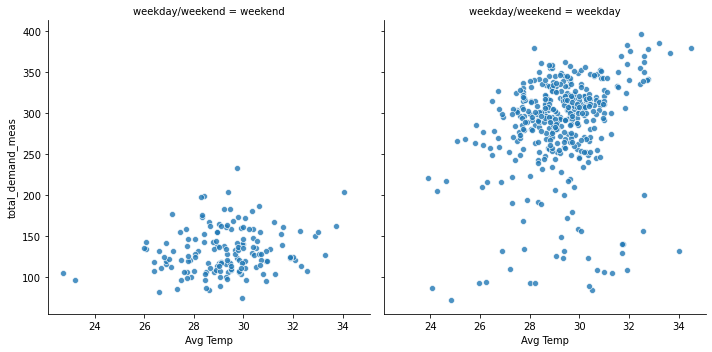

In [ ]:
# Scatter plot for energy consumptions and outdoor temperature
plt.figure(figsize=(10,10))
df_plot = df_temp.copy()
df_plot = df_plot.resample('D').mean()
df_plot['weekday/weekend'] = 'weekday'
df_plot.loc[df_plot['weekday']>4, 'weekday/weekend'] ='weekend'

ax = sns.relplot(x="Avg Temp", y="total_demand_meas", col="weekday/weekend",
                 kind="scatter", data=df_plot, alpha=0.8)

In [ ]:
traindata = df_temp.loc['2018-7':'2019-6'].copy()
testdata = df_temp.loc['2019-7':].copy()

train_labels = traindata['total_demand_meas']
test_labels = testdata['total_demand_meas']

train_features = traindata.drop('total_demand_meas', axis=1)
test_features = testdata.drop('total_demand_meas', axis=1)

LGB_model = lgb.LGBMRegressor()
LGB_model.fit(train_features, train_labels)

testdata['total_demand_pred'] = LGB_model.predict(test_features)

df_temp.loc[testdata.index, 'total_demand_pred'] = testdata['total_demand_pred']

# Calculate the absolute errors
errors = abs(testdata['total_demand_pred'] - test_labels)

# Calculate mean absolute percentage error (MAPE) and add to list
MAPE = 100 * np.mean((errors / test_labels))
NMBE = 100 * (sum(testdata.dropna()['total_demand_meas'] - testdata.dropna()['total_demand_pred']) / (testdata.dropna()['total_demand_meas'].count() * np.mean(testdata.dropna()['total_demand_meas'])))
CVRSME = 100 * ((sum((testdata.dropna()['total_demand_meas'] - testdata.dropna()['total_demand_pred'])**2) / (testdata.dropna()['total_demand_meas'].count()-1))**(0.5)) / np.mean(testdata.dropna()['total_demand_meas'])
RSQUARED = r2_score(testdata.dropna()['total_demand_meas'], testdata.dropna()['total_demand_pred'])

print("MAPE: "+str(round(MAPE,2)))
print("NMBE: "+str(round(NMBE,2)))
print("CVRSME: "+str(round(CVRSME,2)))
print("R SQUARED: "+str(round(RSQUARED,2)))

testdata[['total_demand_meas', 'total_demand_pred']].iplot()

MAPE: inf
NMBE: -4.7
CVRSME: 31.26
R SQUARED: 0.83


In [ ]:
#The third forecasting model with time-series, weather, and holiday features
country = 'thailand'

url = 'https://www.timeanddate.com/holidays/'+country+'/2018'
r = requests.get(url)
df_holiday_2018 = pd.read_html(r.text)[0]
df_holiday_2018.columns = df_holiday_2018.columns.get_level_values(0)
df_holiday_2018 = df_holiday_2018.dropna(how='all')
df_holiday_2018 = df_holiday_2018[['Date', 'Name', 'Type']]
df_holiday_2018['Date'] = '2018 ' + df_holiday_2018['Date']
df_holiday_2018['Date'] = pd.to_datetime(df_holiday_2018['Date'], errors='coerce')
df_holiday_2018 = df_holiday_2018[~df_holiday_2018['Date'].isna()]

url = 'https://www.timeanddate.com/holidays/'+country+'/2019'
r = requests.get(url)
df_holiday_2019 = pd.read_html(r.text)[0]
df_holiday_2019.columns = df_holiday_2019.columns.get_level_values(0)
df_holiday_2019 = df_holiday_2019.dropna(how='all')
df_holiday_2019 = df_holiday_2019[['Date', 'Name', 'Type']]
df_holiday_2019['Date'] = '2019 ' + df_holiday_2019['Date']
df_holiday_2019['Date'] = pd.to_datetime(df_holiday_2019['Date'], errors='coerce')
df_holiday_2019 = df_holiday_2019[~df_holiday_2019['Date'].isna()]


df_holiday = pd.concat([df_holiday_2018, df_holiday_2019], axis=0, ignore_index=True)
df_holiday = df_holiday[df_holiday['Type']=='National holiday']
df_holiday = df_holiday.drop_duplicates(subset=['Date'])
df_holiday = df_holiday.set_index('Date')
df_holiday.loc['2019-12-31', ['Name','Type']]=np.nan
df_holiday = df_holiday.asfreq('D')
df_holiday.loc[df_holiday.index.weekday>=5, 'Name'] = 'weekend'
df_holiday.loc[df_holiday.index.weekday>=5, 'Type'] = 'weekend'
df_holiday.columns = 'holiday_' + df_holiday.columns

df_holiday = df_holiday.reset_index()
df_holiday = df_holiday.rename(columns={'Date':'date'})

df_holiday

date                     holiday_Name      holiday_Type
0   2018-01-01                   New Year's Day  National holiday
1   2018-01-02            Bridge Public Holiday  National holiday
2   2018-01-03                              NaN               NaN
3   2018-01-04                              NaN               NaN
4   2018-01-05                              NaN               NaN
..         ...                              ...               ...
725 2019-12-27                              NaN               NaN
726 2019-12-28                          weekend           weekend
727 2019-12-29                          weekend           weekend
728 2019-12-30  New Year Special Public Holiday  National holiday
729 2019-12-31                              NaN               NaN

[730 rows x 3 columns]

In [ ]:
df_holiday_encode = df_holiday.copy()
df_holiday_encode[['holiday_Name', 'holiday_Type']] = df_holiday_encode[['holiday_Name', 'holiday_Type']].astype('str').apply(LabelEncoder().fit_transform)
df_holiday_encode

date  holiday_Name  holiday_Type
0   2018-01-01            13             0
1   2018-01-02             2             0
2   2018-01-03            24             1
3   2018-01-04            24             1
4   2018-01-05            24             1
..         ...           ...           ...
725 2019-12-27            24             1
726 2019-12-28            25             2
727 2019-12-29            25             2
728 2019-12-30            12             0
729 2019-12-31            24             1

[730 rows x 3 columns]

In [ ]:
# Prepare data for modeling
df_temp = df_powerMeter.reset_index().copy()
df_temp = df_temp.dropna()

# Add timestamp features
df_temp['weekday'] = df_temp['Date'].dt.weekday
df_temp['hour'] = df_temp['Date'].dt.hour
df_temp['date'] =pd.to_datetime(df_temp['Date'].dt.date)

# Add weather features
df_temp = df_temp.merge(df_weather.reset_index(), left_on='date', right_on='index')

# Add holiday features
df_temp = df_temp.merge(df_holiday_encode, on='date')

df_temp = df_temp.set_index('Date').drop(['date', 'index'],axis=1)

df_temp = df_temp.rename(columns={'total_demand':'total_demand_meas'})

df_temp

total_demand_meas  weekday  hour  Avg Temp  Min Temp  \
Date                                                                        
2018-07-01 00:00:00         176.261667        6     0     29.50     25.00   
2018-07-01 01:00:00         177.300000        6     1     29.50     25.00   
2018-07-01 02:00:00         177.048833        6     2     29.50     25.00   
2018-07-01 03:00:00         175.129167        6     3     29.50     25.00   
2018-07-01 04:00:00         183.175000        6     4     29.50     25.00   
...                                ...      ...   ...       ...       ...   
2019-12-31 19:00:00         120.144500        1    19     28.22     23.22   
2019-12-31 20:00:00         124.547667        1    20     28.22     23.22   
2019-12-31 21:00:00         104.895333        1    21     28.22     23.22   
2019-12-31 22:00:00          95.204167        1    22     28.22     23.22   
2019-12-31 23:00:00          91.057667        1    23     28.22     23.22   

                     Max Temp  Precip  holiday_Name  holiday_Type  
Date                                                               
2018-07-01 00:00:00     34.50    17.0            25             2  
2018-07-01 01:00:00     34.50    17.0            25             2  
2018-07-01 02:00:00     34.50    17.0            25             2  
2018-07-01 03:00:00     34.50    17.0            25             2  
2018-07-01 04:00:00     34.50    17.0            25             2  
...                       ...     ...           ...           ...  
2019-12-31 19:00:00     34.78     0.0            24             1  
2019-12-31 20:00:00     34.78     0.0            24             1  
2019-12-31 21:00:00     34.78     0.0            24             1  
2019-12-31 22:00:00     34.78     0.0            24             1  
2019-12-31 23:00:00     34.78     0.0            24             1  

[13176 rows x 9 columns]

In [ ]:
traindata = df_temp.loc['2018-7':'2019-6'].copy()
testdata = df_temp.loc['2019-7':].copy()

train_labels = traindata['total_demand_meas']
test_labels = testdata['total_demand_meas']

train_features = traindata.drop('total_demand_meas', axis=1)
test_features = testdata.drop('total_demand_meas', axis=1)

LGB_model = lgb.LGBMRegressor()
LGB_model.fit(train_features, train_labels)

testdata['total_demand_pred'] = LGB_model.predict(test_features)

df_temp.loc[testdata.index, 'total_demand_pred'] = testdata['total_demand_pred']

# Calculate the absolute errors
errors = abs(testdata['total_demand_pred'] - test_labels)

# Calculate mean absolute percentage error (MAPE) and add to list
MAPE = 100 * np.mean((errors / test_labels))
NMBE = 100 * (sum(testdata.dropna()['total_demand_meas'] - testdata.dropna()['total_demand_pred']) / (testdata.dropna()['total_demand_meas'].count() * np.mean(testdata.dropna()['total_demand_meas'])))
CVRSME = 100 * ((sum((testdata.dropna()['total_demand_meas'] - testdata.dropna()['total_demand_pred'])**2) / (testdata.dropna()['total_demand_meas'].count()-1))**(0.5)) / np.mean(testdata.dropna()['total_demand_meas'])
RSQUARED = r2_score(testdata.dropna()['total_demand_meas'], testdata.dropna()['total_demand_pred'])

print("MAPE: "+str(round(MAPE,2)))
print("NMBE: "+str(round(NMBE,2)))
print("CVRSME: "+str(round(CVRSME,2)))
print("R SQUARED: "+str(round(RSQUARED,2)))

testdata[['total_demand_meas', 'total_demand_pred']].iplot()

MAPE: inf
NMBE: -3.45
CVRSME: 20.88
R SQUARED: 0.92


## Aggregated by different levels

In [ ]:
testdata[['total_demand_meas', 'total_demand_pred']].resample('D').mean().iplot()

In [ ]:
testdata[['total_demand_meas', 'total_demand_pred']].resample('M').mean().iplot(kind='bar')